In [1]:
import geopandas
import pandas as pd
import maup
import sys

import shapely.geometry

sys.path.insert(0, '..')
from read_config import read_yaml

In [2]:
config = read_yaml('../preprocessing_config.yaml')
main_path = '../../'
districts_geo_path = main_path + config['PREPROCESSING']['DATA']['NEVADA']['UNPROCESSED']['GEOMETRY']['DISTRICTS']
precincts_geo_path = main_path + config['PREPROCESSING']['DATA']['NEVADA']['UNPROCESSED']['GEOMETRY']['PRECINCTS']
cb_geo_path = main_path + config['PREPROCESSING']['DATA']['NEVADA']['UNPROCESSED']['GEOMETRY']['CENSUS_BLOCKS']
cb_info_path = main_path + config['PREPROCESSING']['DATA']['NEVADA']['UNPROCESSED']['INFORMATION']['CENSUS_BLOCKS']
county_election_path = main_path + config['PREPROCESSING']['DATA']['NEVADA']['UNPROCESSED']['INFORMATION']['COUNTY_ELECTION']
county_name_fips_path = main_path + config['PREPROCESSING']['DATA']['NEVADA']['UNPROCESSED']['INFORMATION']['COUNTY_NAME_FIPS']

In [3]:
districts_geo = geopandas.read_file(districts_geo_path)
precincts_geo = geopandas.read_file(precincts_geo_path)
cb_geo = geopandas.read_file(cb_geo_path)
cb_info = pd.read_csv(cb_info_path)
county_election = pd.read_excel(county_election_path)
county_name_fips = pd.read_csv(county_name_fips_path)
cb_district_assignment = pd.read_csv('../../preprocessing/data/nevada/unprocessed/BlockAssign_ST32_NV_CD.txt', sep="|")

DriverError: ../../preprocessing/data/nevada/unprocessed/precincts_geo.geojson: No such file or directory

In [261]:
cb_district_assignment.rename(columns={'BLOCKID':'blockId', 'DISTRICT':'districtId'},inplace= True)

In [262]:
cb_district_assignment

,blockId,districtId
0,320019501001000,2
1,320019501001001,2
2,320019501001002,2
3,320019501001003,2
4,320019501001004,2
...,...,...
57404,325100010023015,2
57405,325100010023016,2
57406,325100010023017,2
57407,325109900000001,2


In [263]:
districts_geo.to_crs(cb_geo.crs, inplace=True)
precincts_geo.to_crs(cb_geo.crs, inplace=True)

### Clean and prepare dataframes for merges

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'UATYPE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'geometry'],
      dtype='object')
Index(['GEO_ID', 'NAME', 'P1_001N', 'P1_002N', 'P1_003N', 'P1_004N', 'P1_005N',
       'P1_006N', 'P1_007N', 'P1_008N', 'P1_009N', 'P1_010N', 'P1_011N',
       'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N', 'P1_016N', 'P1_017N',
       'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N', 'P1_022N', 'P1_023N',
       'P1_024N', 'P1_025N', 'P1_026N', 'P1_027N', 'P1_028N', 'P1_029N',
       'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N', 'P1_034N', 'P1_035N',
       'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N', 'P1_040N', 'P1_041N',
       'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N', 'P1_046N', 'P1_047N',
       'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N', 'P1_052N', 'P1_053N',
       'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N', 'P1_058N', 'P1_059N',
       'P1_060N', 'P1_061N'

/Users/kostadindev/.conda/envs/preprocessing/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


                        blockId  population  white  black  asian
1      1000000US320019501001000           0      0      0      0
2      1000000US320019501001001           0      0      0      0
3      1000000US320019501001002           0      0      0      0
4      1000000US320019501001003           0      0      0      0
5      1000000US320019501001004           1      0      0      0
...                         ...         ...    ...    ...    ...
57405  1000000US325100010023015         134     89      0      0
57406  1000000US325100010023016          73     54      1      3
57407  1000000US325100010023017          24      9      0      0
57408  1000000US325109900000001           0      0      0      0
57409  1000000US325109900000002           0      0      0      0

[57409 rows x 5 columns]


In [264]:
print(cb_geo.columns)
print(cb_info.columns)
cb_geo = cb_geo[['GEOID20','COUNTYFP20','geometry']]
cb_geo.rename(columns={'GEOID20': 'blockId','COUNTYFP20':'fips'},inplace = True)
cb_info = cb_info[['GEO_ID', 'P1_001N', 'P1_003N', 'P1_004N', 'P1_006N']]
cb_info.rename(columns= {'GEO_ID':'blockId', 'P1_001N':'population', 'P1_003N':'white', 'P1_004N':'black', 'P1_006N':'asian'},inplace= True)
cb_info = cb_info.iloc[1:]
cb_info['population'] = cb_info['population'].apply(int)
cb_info['white'] = cb_info['white'].apply(int)
cb_info['black'] = cb_info['black'].apply(int)
cb_info['asian'] = cb_info['asian'].apply(int)
print(cb_info)
cb_info['blockId'] = cb_info['blockId'].apply(lambda x: x.split('US')[1])
cb_geo['blockId'] = cb_geo['blockId'].apply(lambda col: str(col))
cb_info['blockId'] = cb_geo['blockId'].apply(lambda col: str(col))

districts_geo = districts_geo[['CD116FP', 'geometry']]
districts_geo.rename(columns={'CD116FP': 'districtId'},inplace = True)
districts_geo['districtId'] = districts_geo['districtId'].apply(int)
# precincts_geo = precincts_geo[['GEOID10', 'geometry']]
# precincts_geo.rename(columns={'GEOID10': 'precinctId'}, inplace=True)
cb_district_assignment.rename(columns={'BLOCKID':'blockId', 'DISTRICT':'districtId'},inplace= True)
cb_district_assignment['blockId'] = cb_district_assignment['blockId'].apply(str)
county_election = county_election[['county','Democrat','Republican', 'Total']]
county_election.rename(columns = {'Democrat':'democrat', 'Republican':'republican', 'Total':'voters'},inplace = True)
county_name_fips['county'] = county_name_fips['county'].apply(lambda x: x.rsplit(' ', 1)[0])
county_name_fips['fips'] = county_name_fips['fips'].apply(lambda x: int(x.split(' ')[0][2:]))
count_name_fips = county_name_fips.drop(columns=['state'])
county_election = county_election.merge(county_name_fips, on='county')

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'UATYPE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'geometry'],
      dtype='object')
Index(['GEO_ID', 'NAME', 'P1_001N', 'P1_002N', 'P1_003N', 'P1_004N', 'P1_005N',
       'P1_006N', 'P1_007N', 'P1_008N', 'P1_009N', 'P1_010N', 'P1_011N',
       'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N', 'P1_016N', 'P1_017N',
       'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N', 'P1_022N', 'P1_023N',
       'P1_024N', 'P1_025N', 'P1_026N', 'P1_027N', 'P1_028N', 'P1_029N',
       'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N', 'P1_034N', 'P1_035N',
       'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N', 'P1_040N', 'P1_041N',
       'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N', 'P1_046N', 'P1_047N',
       'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N', 'P1_052N', 'P1_053N',
       'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N', 'P1_058N', 'P1_059N',
       'P1_060N', 'P1_061N'

In [265]:
cb_district_assignment

,blockId,districtId
0,320019501001000,2
1,320019501001001,2
2,320019501001002,2
3,320019501001003,2
4,320019501001004,2
...,...,...
57404,325100010023015,2
57405,325100010023016,2
57406,325100010023017,2
57407,325109900000001,2


### Approximate democrats and republicans per census block using county data

In [266]:
cb_geo['fips'] =cb_geo['fips'].apply(int)
county_election['fips'] = county_election['fips'].apply(int)
cb_per_county = cb_geo[['blockId','fips']].groupby(by='fips').count()
cb_per_county.reset_index(level=0, inplace = True)
cb_per_county.rename(columns={'blockId':'cbCount'},inplace = True)
county_election = county_election.merge(cb_per_county, on='fips')
county_election['democrat'] = county_election['democrat']/county_election['cbCount']
county_election['republican'] = county_election['republican']/county_election['cbCount']
county_election['voters'] = county_election['voters']/county_election['cbCount']
county_election = county_election[['fips','democrat','republican','voters']]

### Merge geometric data with demographics and election data

In [273]:
cb = cb_geo.merge(cb_info, on='blockId').merge(county_election, on='fips')
print(cb.isna().sum())
print(len(cb))
assert (cb.isna().sum().sum() == 0), "imperfect matching in merging"

blockId       0
fips          0
geometry      0
population    0
white         0
black         0
asian         0
democrat      0
republican    0
voters        0
dtype: int64
57408


In [274]:
### Assign census blocks to districts and precincts

In [275]:
# assignment_cb_districts = maup.assign(cb, districts_geo)
# assert (assignment_cb_districts.isna().sum() == 0), "Error in census block to district assignment"
# cb['district'] = assignment_cb_districts
# assignment_cb_precincts = maup.assign(cb, precincts_geo)
# assert (assignment_cb_precincts.isna().sum() == 0), "Error in census block to precinct assignment"
# cb['precinct'] = assignment_cb_precincts
cb_district_assignment
cb =cb.merge(cb_district_assignment, on='blockId')

In [276]:
cb

,blockId,fips,geometry,population,white,black,asian,democrat,republican,voters,districtId
0,320019507001049,1,"POLYGON ((-118.83864 39.39869, -118.83857 39.3...",0,0,0,0,1.779045,5.443336,9.289380,2
1,320019506003003,1,"POLYGON ((-118.78911 39.49677, -118.78908 39.4...",0,0,0,0,1.779045,5.443336,9.289380,2
2,320019507003042,1,"POLYGON ((-118.98757 39.49546, -118.98752 39.4...",0,0,0,0,1.779045,5.443336,9.289380,2
3,320019506002042,1,"POLYGON ((-118.82618 39.48281, -118.82410 39.4...",0,0,0,0,1.779045,5.443336,9.289380,2
4,320019503021028,1,"POLYGON ((-118.78459 39.46755, -118.78450 39.4...",0,0,0,0,1.779045,5.443336,9.289380,2
...,...,...,...,...,...,...,...,...,...,...,...
57403,320299702003087,29,"POLYGON ((-119.64877 39.29807, -119.64864 39.2...",33,2,1,0,1.938503,4.064171,8.125668,2
57404,320299702001106,29,"POLYGON ((-119.63431 39.51268, -119.63385 39.5...",0,0,0,0,1.938503,4.064171,8.125668,2
57405,320299702001043,29,"POLYGON ((-119.43972 39.50075, -119.43955 39.5...",0,0,0,0,1.938503,4.064171,8.125668,2
57406,320299702003107,29,"POLYGON ((-119.67909 39.27594, -119.67906 39.2...",8,8,0,0,1.938503,4.064171,8.125668,2


In [277]:
#districts_geo['index'] = districts_geo.index
#cb = cb.merge(districts_geo[['districtId', 'index']], left_on='districtId', right_on='index')
# precincts_geo['index'] = precincts_geo.index
# cb = cb.merge(precincts_geo[['precinctId', 'index']], left_on='precinct', right_on='index').drop(
#     columns=['index', 'precinct'])
cb['districtingId'] = 'enacted'
cb = cb[['blockId', 'districtId', 'districtingId', 'population', 'white', 'black', 'asian',
         'democrat','republican','voters','geometry']]
cb

,blockId,districtId,districtingId,population,white,black,asian,democrat,republican,voters,geometry
0,320019507001049,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.83864 39.39869, -118.83857 39.3..."
1,320019506003003,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.78911 39.49677, -118.78908 39.4..."
2,320019507003042,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.98757 39.49546, -118.98752 39.4..."
3,320019506002042,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.82618 39.48281, -118.82410 39.4..."
4,320019503021028,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.78459 39.46755, -118.78450 39.4..."
...,...,...,...,...,...,...,...,...,...,...,...
57403,320299702003087,2,enacted,33,2,1,0,1.938503,4.064171,8.125668,"POLYGON ((-119.64877 39.29807, -119.64864 39.2..."
57404,320299702001106,2,enacted,0,0,0,0,1.938503,4.064171,8.125668,"POLYGON ((-119.63431 39.51268, -119.63385 39.5..."
57405,320299702001043,2,enacted,0,0,0,0,1.938503,4.064171,8.125668,"POLYGON ((-119.43972 39.50075, -119.43955 39.5..."
57406,320299702003107,2,enacted,8,8,0,0,1.938503,4.064171,8.125668,"POLYGON ((-119.67909 39.27594, -119.67906 39.2..."


In [278]:
cb

,blockId,districtId,districtingId,population,white,black,asian,democrat,republican,voters,geometry
0,320019507001049,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.83864 39.39869, -118.83857 39.3..."
1,320019506003003,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.78911 39.49677, -118.78908 39.4..."
2,320019507003042,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.98757 39.49546, -118.98752 39.4..."
3,320019506002042,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.82618 39.48281, -118.82410 39.4..."
4,320019503021028,2,enacted,0,0,0,0,1.779045,5.443336,9.289380,"POLYGON ((-118.78459 39.46755, -118.78450 39.4..."
...,...,...,...,...,...,...,...,...,...,...,...
57403,320299702003087,2,enacted,33,2,1,0,1.938503,4.064171,8.125668,"POLYGON ((-119.64877 39.29807, -119.64864 39.2..."
57404,320299702001106,2,enacted,0,0,0,0,1.938503,4.064171,8.125668,"POLYGON ((-119.63431 39.51268, -119.63385 39.5..."
57405,320299702001043,2,enacted,0,0,0,0,1.938503,4.064171,8.125668,"POLYGON ((-119.43972 39.50075, -119.43955 39.5..."
57406,320299702003107,2,enacted,8,8,0,0,1.938503,4.064171,8.125668,"POLYGON ((-119.67909 39.27594, -119.67906 39.2..."


In [ ]:
cb_path = main_path + config['PREPROCESSING']['DATA']['NEVADA']['PROCESSED']['ENACTED']['CENSUS_BLOCKS']
cb.to_file(cb_path, driver="GeoJSON")

In [279]:
cb.groupby('districtId').sum()

,population,white,black,asian,democrat,republican,voters
districtId,,,,,,,
1,307370,157568,30213,26985,112419.279752,77974.880206,266242.724745
2,1365280,699363,135484,120073,119907.305995,166748.609202,388975.436355
3,467493,241355,44175,40450,169056.694665,117259.028377,400377.187287
4,964471,490177,94867,85195,166381.940543,130202.038879,413066.362234


<AxesSubplot:>

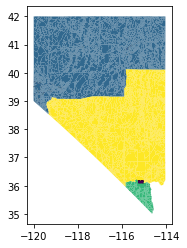

In [280]:
cb.plot('districtId')

In [205]:
cb

,blockId,fips,geometry,population,white,black,asian,democrat,republican,voters
0,320019507001049,1,"POLYGON ((-118.83864 39.39869, -118.83857 39.3...",0,0,0,0,1.779045,5.443336,9.289380
1,320019506003003,1,"POLYGON ((-118.78911 39.49677, -118.78908 39.4...",0,0,0,0,1.779045,5.443336,9.289380
2,320019507003042,1,"POLYGON ((-118.98757 39.49546, -118.98752 39.4...",0,0,0,0,1.779045,5.443336,9.289380
3,320019506002042,1,"POLYGON ((-118.82618 39.48281, -118.82410 39.4...",0,0,0,0,1.779045,5.443336,9.289380
4,320019503021028,1,"POLYGON ((-118.78459 39.46755, -118.78450 39.4...",0,0,0,0,1.779045,5.443336,9.289380
...,...,...,...,...,...,...,...,...,...,...
57403,320299702003087,29,"POLYGON ((-119.64877 39.29807, -119.64864 39.2...",33,2,1,0,1.938503,4.064171,8.125668
57404,320299702001106,29,"POLYGON ((-119.63431 39.51268, -119.63385 39.5...",0,0,0,0,1.938503,4.064171,8.125668
57405,320299702001043,29,"POLYGON ((-119.43972 39.50075, -119.43955 39.5...",0,0,0,0,1.938503,4.064171,8.125668
57406,320299702003107,29,"POLYGON ((-119.67909 39.27594, -119.67906 39.2...",8,8,0,0,1.938503,4.064171,8.125668


In [ ]:
cb['population'].max()

In [ ]:
cb[cb['districtId'] == 2].plot()

In [ ]:
cb[cb['districtId'] == 2]['population'].sum()